## Gaussian Process Regression Implementation
### Mark Ma, CS 235, Fall 2021, Dr. Papalexakis

<ipython-input-1-e5f1204a9612>:77: RuntimeWarning: divide by zero encountered in log
  LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
E:\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
E:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Time for fitting - implemented income only: 2118.681


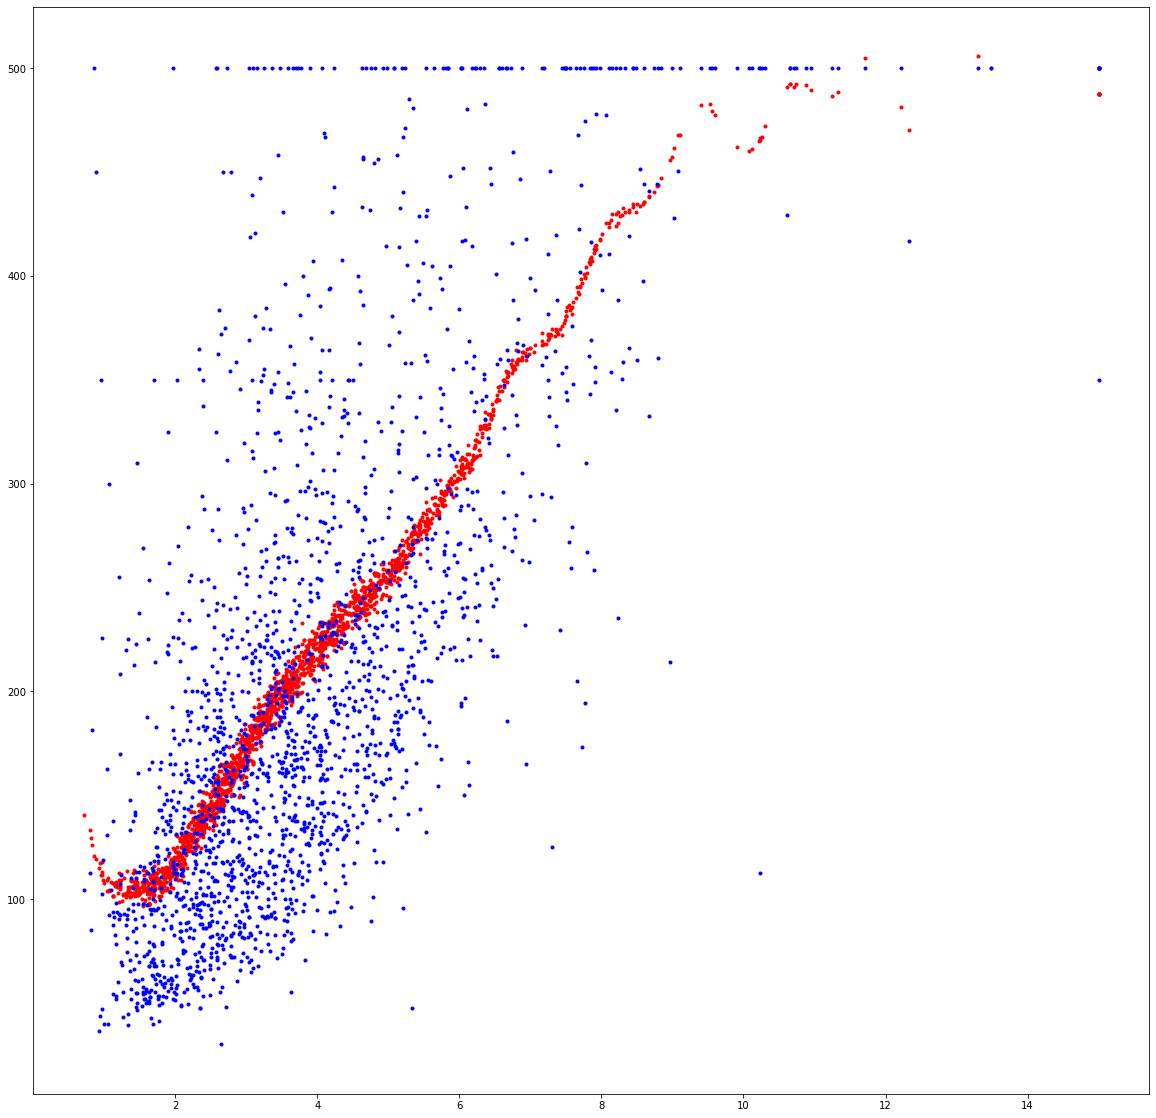

<ipython-input-1-e5f1204a9612>:77: RuntimeWarning: divide by zero encountered in log
  LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
E:\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
E:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Time for fitting - implemented lat+long: 3375.693


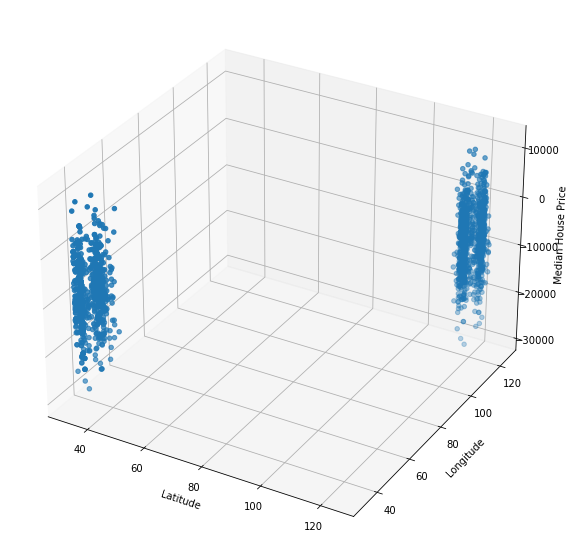

<ipython-input-1-e5f1204a9612>:77: RuntimeWarning: divide by zero encountered in log
  LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
E:\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
E:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Time for fitting - implemented all features: 10430.769
Implemented MSE, income only: 


20678.316400639542

Implemented MSE, latitude and longitude: 


101806007.11930823

Implemented MSE, all features: 


189122251.99085176

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline


class GaussianProcess:
    """A Gaussian Process class for creating and exploiting  
    a Gaussian Process model"""
    
    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer


    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K        

    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, logarithm of the correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
        
        # Update attributes
        self.K, self.inv_K , self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr
        
        return -LnLike.flatten()    

    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)    
    
    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()
    
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )
        
        Output
        ------
        RMSE: the root mean square error"""
        
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE    

# get datasets
obs_df = pd.read_csv('CA_HomePrice_Obs.csv')
val_df = pd.read_csv('CA_HomePrice_Val.csv')
test_df = pd.read_csv('CA_HomePrice_Test.csv')

# obs_df = pd.read_csv('CA_Short_Obs.csv')
# test_df = pd.read_csv('CA_Short_Test.csv')

obs_df_array = np.asarray(obs_df)
obs_price = obs_df_array[:, 0].astype('float') / 1000
obs_income = obs_df_array[:, 1]
obs_lat = obs_df_array[:, 7]
obs_long = np.absolute(obs_df_array[:, 8])
obs_dist_coast = np.absolute(obs_df_array[:, 9])
obs_br_density = np.absolute(obs_df_array[:, 14])
obs_avg_rms = np.absolute(obs_df_array[:, 15])
obs_dist_city = np.absolute(obs_df_array[:, 16])

val_df_array = np.asarray(val_df)
val_price = val_df_array[:, 0].astype('float') / 1000  
val_income = val_df_array[:, 1]
val_lat = val_df_array[:, 7]
val_long = np.absolute(val_df_array[:, 8])
val_dist_coast = np.absolute(val_df_array[:, 9])
val_br_density = np.absolute(val_df_array[:, 14])
val_avg_rms = np.absolute(val_df_array[:, 15])
val_dist_city = np.absolute(val_df_array[:, 16])

test_df_array = np.asarray(test_df)
test_price = test_df_array[:, 0].astype('float') / 1000 
test_income = test_df_array[:, 1]
test_lat = test_df_array[:, 7]
test_long = np.absolute(test_df_array[:, 8])
test_dist_coast = np.absolute(test_df_array[:, 9])
test_br_density = np.absolute(test_df_array[:, 14])
test_avg_rms = np.absolute(test_df_array[:, 15])
test_dist_city = np.absolute(test_df_array[:, 16])

#
# Income only
#
X_train = np.asarray([obs_income]).reshape(-1,1)
Y_train = obs_price.reshape(-1,1)
x_test = np.asarray([test_income]).reshape(-1,1)
y_actual = test_price.reshape(-1,1)

# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GaussianProcess(n_restarts=1, optimizer='L-BFGS-B'))])

stime = time.time()
pipe.fit(X_train, Y_train)
print("Time for fitting - implemented income only: %.3f" % (time.time() - stime))

# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(x_test)

imp_mse_income = np.mean((y_actual - y_pred)**2)

# Create a 2D plot of price v income
fig_2D = plt.figure(figsize=(20,20))
plt.plot(x_test, y_pred, 'r.', label='Predictions')
plt.plot(x_test, y_actual, 'b.', label='Actual')
plt.show()

#
# latitude and longitude
#
X_train = np.asarray([obs_lat, obs_long]).reshape(-1,2)
Y_train = obs_price.reshape(-1,1)
x_test = np.asarray([test_lat, test_long]).reshape(-1,2)
y_actual = test_price.reshape(-1,1)

# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GaussianProcess(n_restarts=1, optimizer='L-BFGS-B'))])

stime = time.time()
pipe.fit(X_train, Y_train)
print("Time for fitting - implemented lat+long: %.3f" % (time.time() - stime))

# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(x_test)

imp_mse_latlong = np.mean((y_actual - y_pred)**2)

# Create a 3D plot of price v lat+long
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_test[:,0], x_test[:,1], y_pred, marker='o')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Median House Price')

plt.show()

#
# All features
#
X_train = np.asarray([obs_income, obs_lat, obs_long, obs_dist_coast, obs_br_density, obs_avg_rms, obs_dist_city]).reshape(-1,7)
Y_train = obs_price.reshape(-1,1)
x_test = np.asarray([test_income, test_lat, test_long, test_dist_coast, test_br_density, test_avg_rms, test_dist_city]).reshape(-1,7)
y_actual = test_price.reshape(-1,1)

# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GaussianProcess(n_restarts=1, optimizer='L-BFGS-B'))])

stime = time.time()
pipe.fit(X_train, Y_train)
print("Time for fitting - implemented all features: %.3f" % (time.time() - stime))

# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(x_test)

imp_mse_all = np.mean((y_actual - y_pred)**2)


print("Implemented MSE, income only: ")
display(imp_mse_income)

print("Implemented MSE, latitude and longitude: ")
display(imp_mse_latlong)

print("Implemented MSE, all features: ")
display(imp_mse_all)